In [1]:
from discopy import Ty, Id, Box, Diagram, Word

# POS TAGS:
s, n, np, adj, tv, iv, vp, rpron = Ty('S'), Ty('N'), Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP'), Ty('RPRON')

# The CFG's production rules are boxes.

R0 = Box('R0', np @ vp, s)
R1 = Box('R1', tv @ np , vp)
R2 = Box('R2', adj @ n, np)
R3 = Box('R3', iv, vp)
R4 = Box('R4', n, np)
R5 = Box('R5', n @ rpron @ vp, np)

# WORDS:
nouns = ['Bojack', 'Diane', 'Eve', 'Fiona']
tverbs = ['loves', 'kills']
iverbs = ['sleeps', 'dies']
adjs = []
rprons = ['who']

nouns0 = [Word(x, n) for x in nouns]
tverbs0 = [Word(x, tv) for x in tverbs]
iverbs0 = [Word(x, iv) for x in iverbs]
adjs0 = [Word(x, adj) for x in adjs]
rprons0 = [Word(x, rpron) for x in rprons]

vocab = nouns0 + tverbs0 + iverbs0 + adjs0 + rprons0
prods = [R0, R1, R3, R4, R5]

## Generating sentences from a CFG

In [2]:
import random

class CFG:
    def __init__(self, *productions):
        self._productions = productions
        
    @property
    def productions(self):
        return self._productions

    def generate(self, start, max_sentences, max_depth, max_iter=100,
                 remove_duplicates=False):
        """
        Generate sentences from a context-free grammar.
        Assumes the only terminal symbol is Ty().

        Parameters
        ----------
        start : type
            root of the generated trees.
        max_sentences : int
            maximum number of sentences to generate.
        max_depth : int
            maximum depth of the trees.
        max_iter : int
            maximum number of iterations, set to 100 by default.
        remove_duplicates : bool
            if set to True only distinct syntax trees will be generated.
        """
        prods, cache = list(self.productions), set()
        n, iter = 0, 0
        while n < max_sentences and iter < max_iter:
            iter += 1
            sentence = Id(start)
            depth = 0
            while depth < max_depth:
                if sentence.dom == Ty():
                    if remove_duplicates and sentence in cache:
                        break
                    yield sentence
                    if remove_duplicates:
                        cache.add(sentence)
                    n += 1
                    break
                tag = sentence.dom[0]
                random.shuffle(prods)
                for prod in prods:
                    if Ty(tag) == prod.cod:
                        sentence = sentence << prod @ Id(sentence.dom[1:])
                        depth += 1
                        break

productions = prods + vocab
cfg = CFG(*productions)
gen = cfg.generate(s, 30, 12, max_iter=1000, remove_duplicates=True)

In [3]:
sentences = []
for sentence in gen:
    sentences += [sentence]

## Getting the corresponding pregroup diagrams with a functor

In [4]:
from discopy.rigid import Cup, Cap, Functor

# Dict from POS tags to Pregroup types:
ob = {n : n, s: s, adj: n @ n.l, tv: n.r @ s @ n.l, iv: n.r @ s, vp:  n.r @ s, np: n, rpron: n.r @ n @ s.l @ n}

nouns1 = [Word(x, n) for x in nouns]
tverbs1 = [Word(x, ob[tv]) for x in tverbs]
iverbs1 = [Word(x, ob[iv]) for x in iverbs]
adjs1 = [Word(x, ob[adj]) for x in adjs]
rprons1 = [Word(x, ob[rpron]) for x in rprons]

new_vocab = nouns1 + tverbs1 + iverbs1 + adjs1 + rprons1

# Dict from CFG rules to Pregroup reductions: 
ar = {R0: Cup(n, n.r) @ Id(s), 
      R1: Id(n.r @ s) @ Cup(n.l, n),
      R2: Id(n) @ Cup(n.l, n),
      R3 : Id( n.r @ s),
      R4: Id(n),
      R5: Cup(n, n.r) @ Id(n) @ Diagram.cups(s.l @ n, n.r @ s)}

arx = {vocab[i]: new_vocab[i] for i in range(len(vocab))}
ar.update(arx)

T2P = Functor(ob, ar)

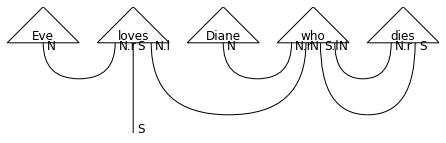

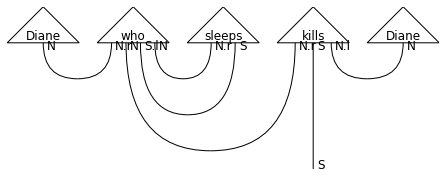

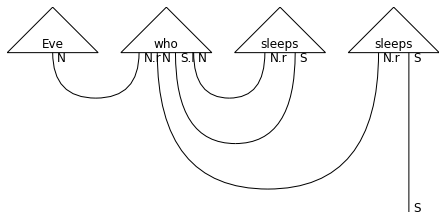

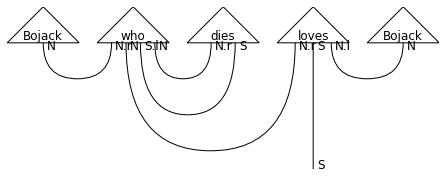

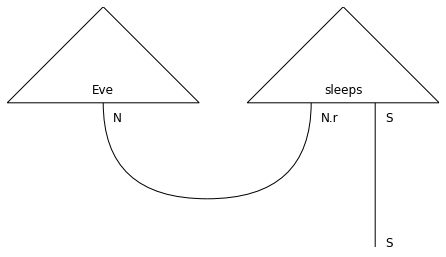

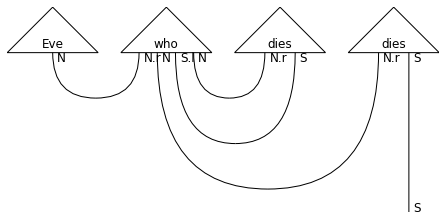

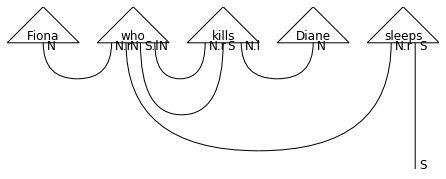

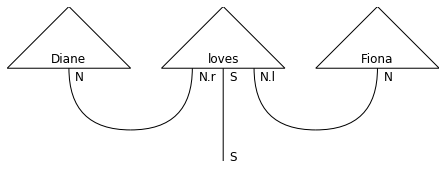

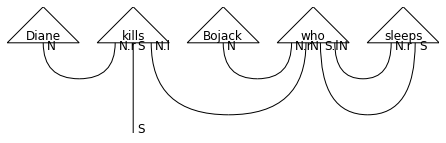

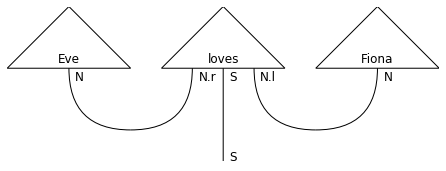

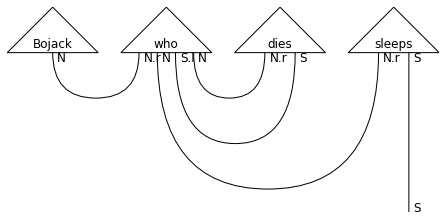

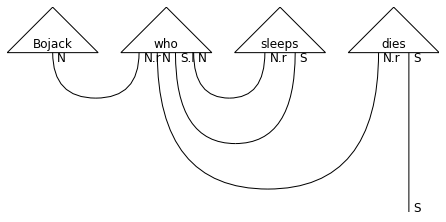

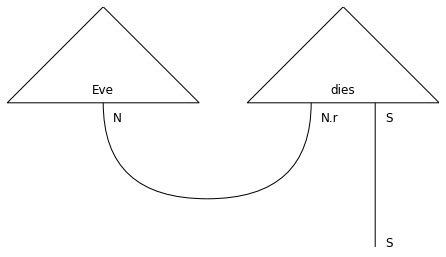

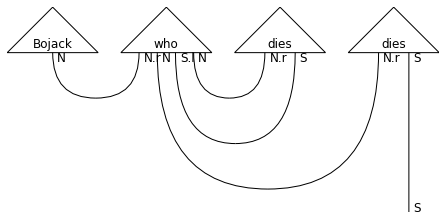

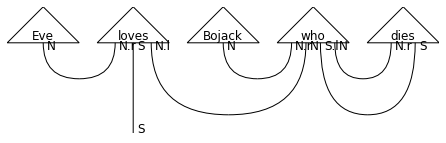

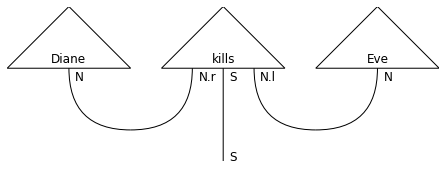

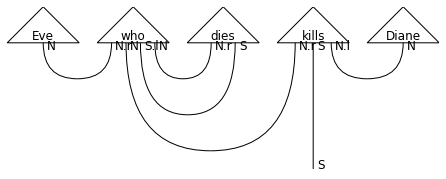

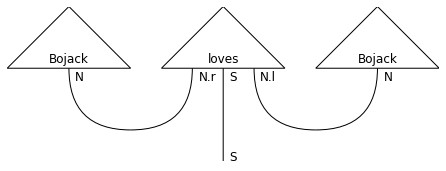

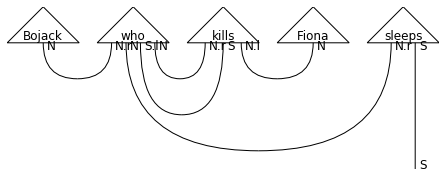

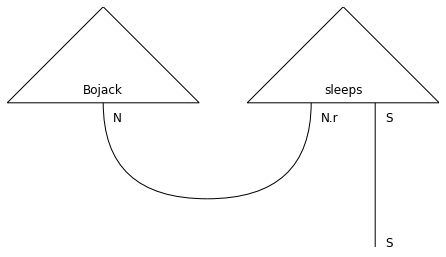

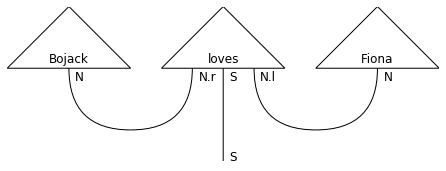

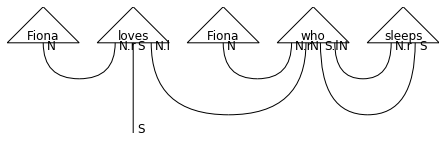

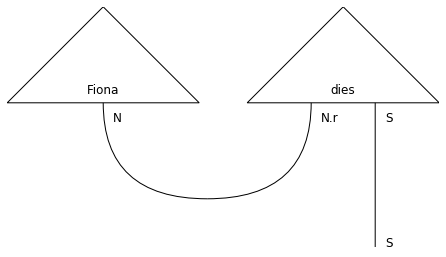

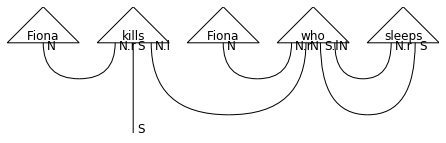

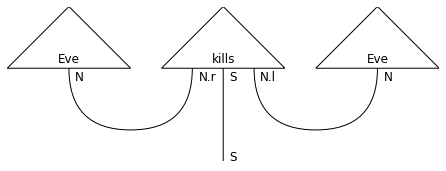

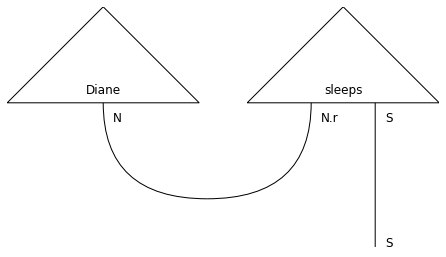

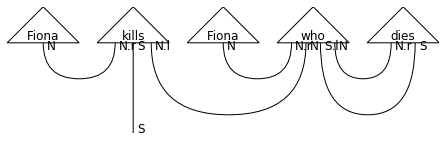

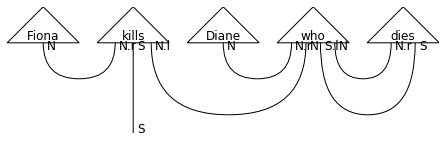

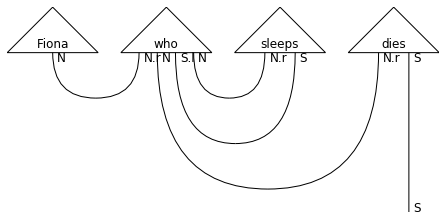

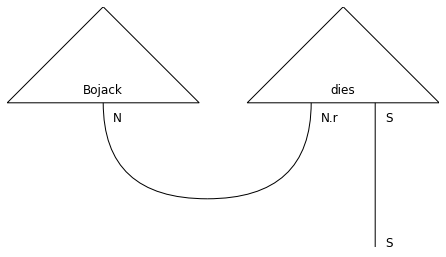

In [6]:
from discopy.pregroup import draw
for sentence in sentences:
    draw(T2P(sentence))